# Potato Leaf Disease Classification

## Importing the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2022-11-28 12:17:30.459426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 12:17:30.459493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Setting the Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

## Import Data into the TF Dataset Object

To achieve this, we will use the image_dataset_from_directory function.

https://keras.io/api/preprocessing/image/

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", # name of the dataset directory
    shuffle=True, # whether to shuffle the data. Seting it to false sorts the data in alphanumeric order
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # size to resize the images after they are read from the disk
    batch_size = BATCH_SIZE # size of the data batches. 32 is the default
)

Found 2152 files belonging to 3 classes.


2022-11-28 12:17:39.639718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-28 12:17:39.639820: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 12:17:39.639926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kim): /proc/driver/nvidia/version does not exist
2022-11-28 12:17:39.640644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Checking the Class Names

In [4]:
class_names = dataset.class_names

class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Checking Dataset Length

In [5]:
len(dataset)

68

## Visualizing Some Images

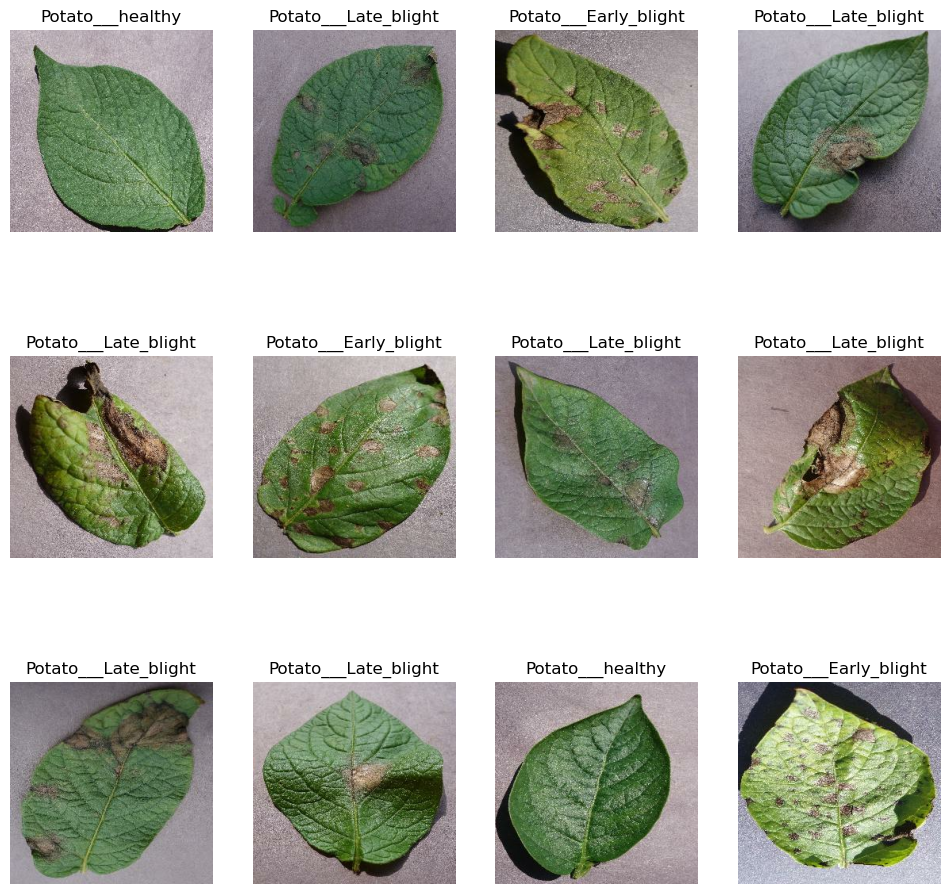

In [6]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


## Splitting the Dataset

Datasets:

    - Training dataset: to train the model -> 80%
    - Valiation dataset: to be tested against while training -> 10%
    - Test dataset: to be tested against the trained model -> 10%

In [7]:
def get_dataset_partitions(ds, train_set=0.8, val_set=0.1, test_set=0.1, shuffle=True, shuffle_size=10000):
    assert (train_set + test_set + val_set) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_set * ds_size)
    val_size = int(val_set * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
# Confirming the length of the sets

print("Training dataset size:", len(train_ds))
print("Testing dataset size:", len(test_ds))
print("Validation dataset size:", len(val_ds))

Training dataset size: 54
Testing dataset size: 8
Validation dataset size: 6


## Cache, Shuffle, and Prefetch the Dataset


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Normalization and Resizing Layer

Before feeding the images to the network, they should be resized to the desired size. Moreover, to improve model performance, the image pixel value should be normalized (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence it can be added as a layer in the Sequential Model.

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data Augmentation

Data augmentation comes in handy when data is not enough. It helps in boosting the accuracy of the model by augmenting the data. Out of one image, you can create more images by applying a horizontal flip, adjusting the image contrast, zooming the image, rotating the image, etc. For this project, I will apply a random flip and random rotation

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

## Model Architecture

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model

Using adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Training the network

In [16]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
54/54 [==============================] - 388s 7s/step - loss: 0.9213 - accuracy: 0.4728 - val_loss: 0.9085 - val_accuracy: 0.3594
Epoch 2/5
54/54 [==============================] - 322s 6s/step - loss: 0.8066 - accuracy: 0.6082 - val_loss: 0.7219 - val_accuracy: 0.6250
Epoch 3/5
54/54 [==============================] - 284s 5s/step - loss: 0.6343 - accuracy: 0.7338 - val_loss: 0.4954 - val_accuracy: 0.7656
Epoch 4/5
54/54 [==============================] - 279s 5s/step - loss: 0.5051 - accuracy: 0.7992 - val_loss: 0.6280 - val_accuracy: 0.7135
Epoch 5/5
54/54 [==============================] - 278s 5s/step - loss: 0.2868 - accuracy: 0.8912 - val_loss: 0.2064 - val_accuracy: 0.9323


## Plotting the Accuracy and Loss Curves

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

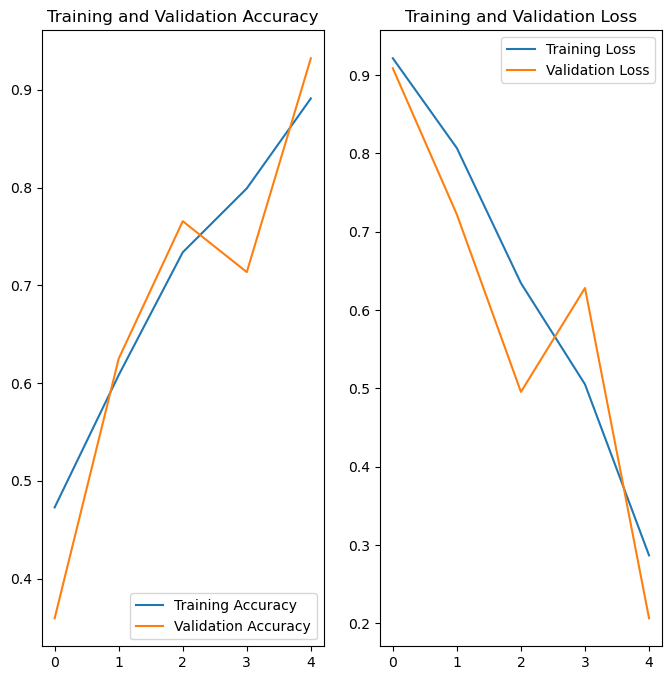

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run Prediction on a Sample Image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


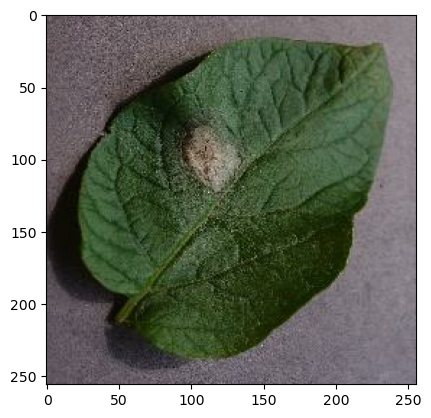

In [19]:


import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



### Inference Function

In [20]:


def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



### Prediction on a Few Images

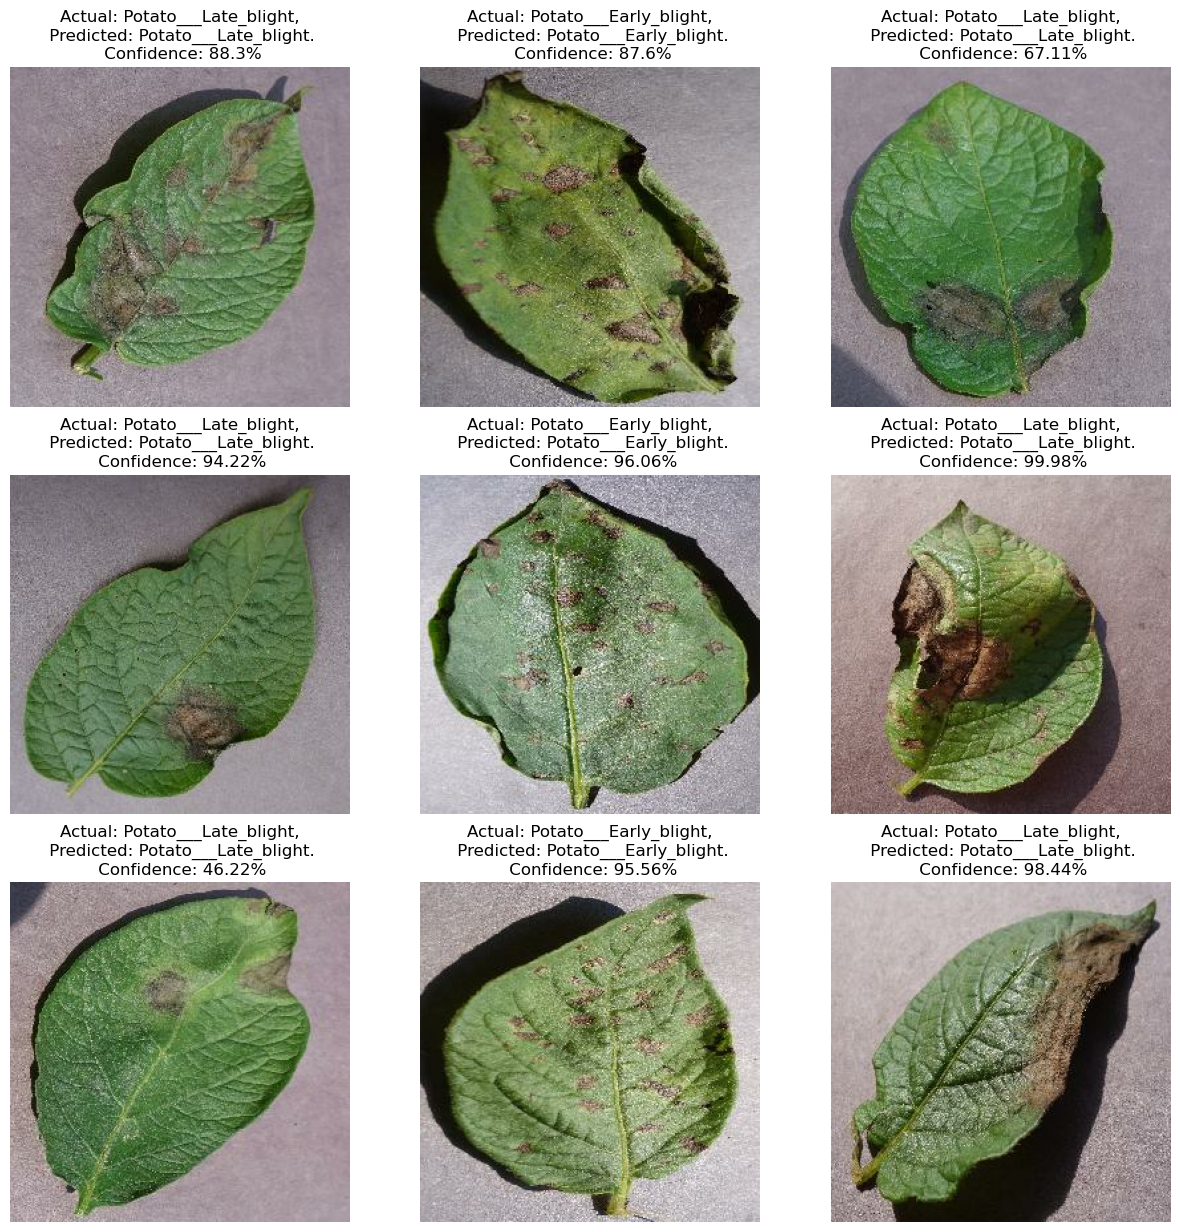

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [22]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

## Saving the Model as a Single File

In [23]:
model.save(f"../models/potatodiseases.h5")